# COVID-19 and Viral Pneumonia Detection Tool
### 1. Loading and Exploring Dataset

In [5]:
import os
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

In [6]:
data_path = pathlib.Path("/Users/thailersimmons/iitClass/cs484Project/COVID_IEEE")  
assert data_path.exists(), "Dataset folder not found"

In [7]:
# === Count Images in Each Class ===
counts = {folder.name: len(list(folder.glob("*")))
          for folder in data_path.iterdir() if folder.is_dir()}

print("Number of images in each class:")
for label, count in counts.items():
    print(f"{label}: {count}")

Number of images in each class:
normal: 668
covid: 536
virus: 619


In [8]:
# === Create Data Frame ===
data = [(str(img), folder.name) for folder in data_path.iterdir() if folder.is_dir() for img in folder.glob("*")]
df = pd.DataFrame(data, columns=["filepath", "label"])

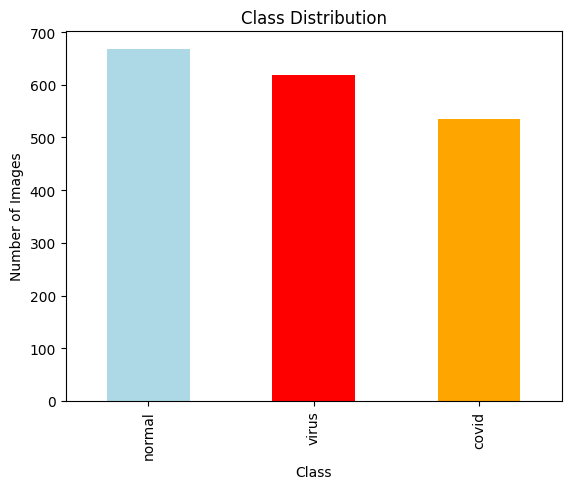

In [9]:
# ==== Class Distribution ===
df["label"].value_counts().plot(kind="bar", color=['lightblue','red','orange'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

Found 1708 files belonging to 3 classes.


2025-10-16 20:13:30.897672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


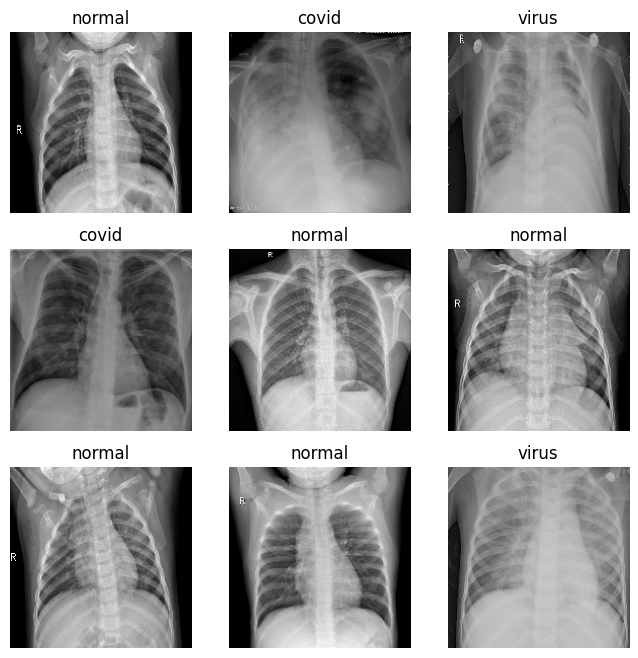

In [14]:
# === Load/Display Images ===
dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    image_size=(180, 180),
    batch_size=9,
    shuffle=True
)

class_names = dataset.class_names
plt.figure(figsize=(8,8))
for images, labels in dataset.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

### 2. Build & Train Baseline CNN Model

### data prep

In [12]:
# Parameters
batch_size = 32
img_height = 180
img_width = 180
random_seed = 42

# 1. Training Dataset (80%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="training",
    seed=random_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# 2. Validation Dataset (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=random_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# 3. Configure for performance (cache in memory)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 3

Found 1708 files belonging to 3 classes.
Using 1367 files for training.
Found 1708 files belonging to 3 classes.
Using 341 files for validation.


### baseline model

In [25]:
def build_baseline_model():
    model = models.Sequential([
        # Rescale inputs from [0, 255] to [0, 1]
        layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        
        # Conv Block 1
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        # Conv Block 2
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        # Conv Block 3
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        # Dense Head
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

baseline_model = build_baseline_model()
baseline_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

print("Training Baseline Model...")
history_baseline = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15  # Standard starting point
)

Training Baseline Model...
Epoch 1/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.7337 - loss: 0.6078 - val_accuracy: 0.8827 - val_loss: 0.3025
Epoch 2/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9181 - loss: 0.2311 - val_accuracy: 0.9326 - val_loss: 0.2462
Epoch 3/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9364 - loss: 0.1904 - val_accuracy: 0.9150 - val_loss: 0.2576
Epoch 4/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9466 - loss: 0.1456 - val_accuracy: 0.9267 - val_loss: 0.1717
Epoch 5/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9620 - loss: 0.0999 - val_accuracy: 0.9355 - val_loss: 0.2061
Epoch 6/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9751 - loss: 0.0782 - val_accuracy: 0.9355 - val_loss: 0.2172
Epoch 7/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9795 - loss: 0.0637 - val_accuracy: 0.9384 - val_loss: 0.2025
Epoch 8/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9700 - loss: 0.067

### updated model

Data Augmentation and Regularization.

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Lighter Augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
  layers.RandomRotation(0.05), 
  layers.RandomZoom(0.05),     
])

def build_tuned_model():
    model = models.Sequential([
        data_augmentation,
        layers.Rescaling(1./255),
        
        # Block 1
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        # Block 2
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        # Block 3
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        # Block 4
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        layers.Dropout(0.2),
        layers.Flatten(),
        
        # Dense Head
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

improved_model = build_tuned_model()
improved_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# --- FIX IS HERE ---
# Define early_stopping before using it
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train
history_improved = improved_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30, 
    callbacks=[early_stopping] # Now this variable exists
)

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - accuracy: 0.5091 - loss: 0.9380 - val_accuracy: 0.8328 - val_loss: 0.4402
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - accuracy: 0.7549 - loss: 0.5745 - val_accuracy: 0.9062 - val_loss: 0.3775
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - accuracy: 0.8259 - loss: 0.4633 - val_accuracy: 0.8680 - val_loss: 0.3490
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - accuracy: 0.8486 - loss: 0.3860 - val_accuracy: 0.8504 - val_loss: 0.4294
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - accuracy: 0.8837 - loss: 0.3298 - val_accuracy: 0.9326 - val_loss: 0.2006
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 259ms/step - accuracy: 0.8961 - loss: 0.2791 - val_accuracy: 0.9326 - val_loss: 0.1939
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 257ms/step - accuracy: 0.9056 - loss: 0.2658 - val_accuracy: 0.9003 - val_loss: 0.2875
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 262ms/step - accuracy: 0.9034 - loss: 0.2626 - val_accu

### pre-trained model

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Load the pre-trained base model (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(180, 180, 3), 
    include_top=False,  # Exclude the classifier layers from the original model
    weights='imagenet'
)

# 2. Freeze the base model
# We don't want to destroy the learned patterns, so we make it non-trainable
base_model.trainable = False

# 3. Build the new model on top
transfer_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax') # 3 classes: Normal, Covid, Virus
])

# 4. Compile
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# 5. Train
print("Starting Transfer Learning...")
history_transfer = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

/var/folders/yt/bs22fw9d3p70r62nx_hfmysw0000gn/T/ipykernel_6577/1884563449.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Starting Transfer Learning...
Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.3731 - loss: 1.1885 - val_accuracy: 0.4985 - val_loss: 1.0000
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.4916 - loss: 1.0303 - val_accuracy: 0.6422 - val_loss: 0.8530
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.5647 - loss: 0.8873 - val_accuracy: 0.6921 - val_loss: 0.7612
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.6437 - loss: 0.7954 - val_accuracy: 0.7302 - val_loss: 0.6993
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.6774 - loss: 0.7414 - val_accuracy: 0.7947 - val_loss: 0.6344
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.7286 - loss: 0.6845 - val_accuracy: 0.7918 - val_loss: 0.5981
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.7374 - loss: 0.6365 - val_accuracy: 0.7977 - val_loss: 0.5671
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.7527 - loss: 0.

Fine tuning

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models

# ==========================================
# STEP 1: INITIAL TRANSFER LEARNING (FROZEN)
# ==========================================

# 1. Load the pre-trained base model (MobileNetV2)
# We use include_top=False to exclude the ImageNet classifier at the top
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(180, 180, 3), 
    include_top=False, 
    weights='imagenet'
)

# 2. Freeze the base model
# This prevents the pre-trained weights from being destroyed during the initial training
base_model.trainable = False

# 3. Build the classifier head
transfer_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax') # 3 classes: Normal, Covid, Virus
])

# 4. Compile the model
# We use a standard learning rate (0.0001) for this phase
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# 5. Train the top layer (Transfer Learning)
print("Starting Initial Transfer Learning...")
history_transfer = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

# 1. Define the Early Stopping Callback
early_stopping_fine = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',       # Watch the validation loss
    patience=5,               # Stop if loss doesn't improve for 5 epochs
    restore_best_weights=True, # CRITICAL: Revert to the weights from the best epoch
    verbose=1
)

# 2. Unfreeze the base model
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 3. Recompile (Low Learning Rate)
transfer_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

# 4. Train with the Callback
print("Starting Fine-Tuning with Early Stopping...")

total_epochs = 50 # Set a high cap, let Early Stopping decide when to stop

history_fine = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history_transfer.epoch[-1],
    callbacks=[early_stopping_fine] 
)


/var/folders/yt/bs22fw9d3p70r62nx_hfmysw0000gn/T/ipykernel_6577/2129893516.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Starting Initial Transfer Learning...
Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.4184 - loss: 1.1202 - val_accuracy: 0.5396 - val_loss: 0.9545
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.5369 - loss: 0.9866 - val_accuracy: 0.6540 - val_loss: 0.8234
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.5940 - loss: 0.8664 - val_accuracy: 0.7419 - val_loss: 0.7311
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.6657 - loss: 0.7722 - val_accuracy: 0.7654 - val_loss: 0.6661
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.6920 - loss: 0.7188 - val_accuracy: 0.7947 - val_loss: 0.6235
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.7330 - loss: 0.6594 - val_accuracy: 0.7977 - val_loss: 0.5808
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.7491 - loss: 0.6272 - val_accuracy: 0.8035 - val_loss: 0.5527
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.7652 - 

### 4. Evaluate Model Performances

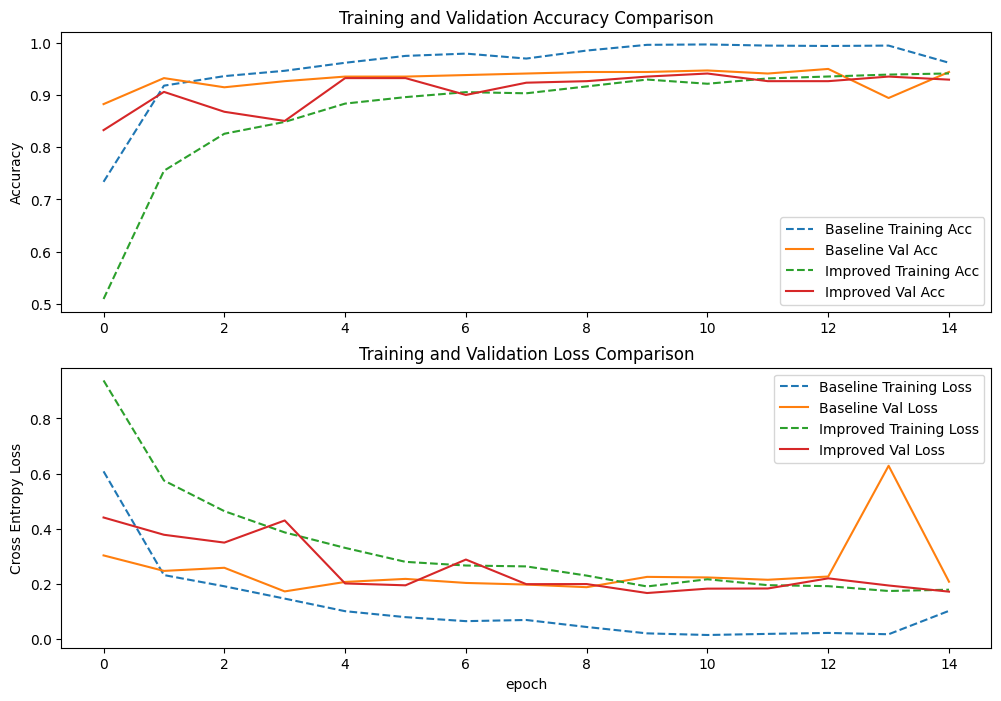

In [28]:
acc = history_baseline.history['accuracy']
val_acc = history_baseline.history['val_accuracy']
loss = history_baseline.history['loss']
val_loss = history_baseline.history['val_loss']

acc_imp = history_improved.history['accuracy']
val_acc_imp = history_improved.history['val_accuracy']
loss_imp = history_improved.history['loss']
val_loss_imp = history_improved.history['val_loss']

plt.figure(figsize=(12, 8))

# Plot Accuracy
plt.subplot(2, 1, 1)
plt.plot(acc, label='Baseline Training Acc', linestyle='--')
plt.plot(val_acc, label='Baseline Val Acc')
plt.plot(acc_imp, label='Improved Training Acc', linestyle='--')
plt.plot(val_acc_imp, label='Improved Val Acc')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison')

# Plot Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Baseline Training Loss', linestyle='--')
plt.plot(val_loss, label='Baseline Val Loss')
plt.plot(loss_imp, label='Improved Training Loss', linestyle='--')
plt.plot(val_loss_imp, label='Improved Val Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy Loss')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('epoch')
plt.show()

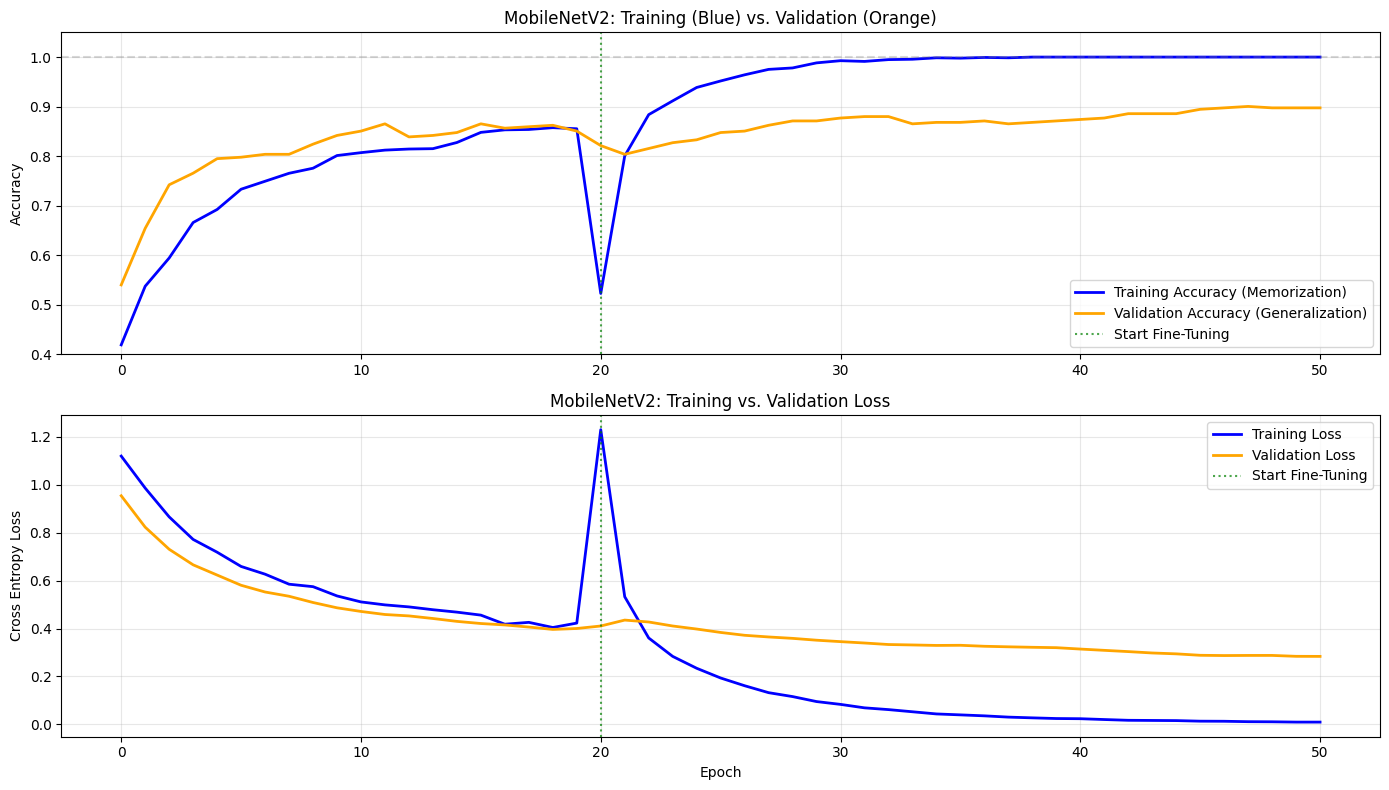

In [31]:
import matplotlib.pyplot as plt

# 1. Combine the Training and Validation histories for MobileNet
# (Stitching the Transfer Learning + Fine Tuning phases together)
acc = history_transfer.history['accuracy'] + history_fine.history['accuracy']
val_acc = history_transfer.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history_transfer.history['loss'] + history_fine.history['loss']
val_loss = history_transfer.history['val_loss'] + history_fine.history['val_loss']

# 2. Plot
plt.figure(figsize=(14, 8))

# --- Plot 1: Accuracy (The "1.0" View) ---
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy (Memorization)', color='blue', linewidth=2)
plt.plot(val_acc, label='Validation Accuracy (Generalization)', color='orange', linewidth=2)

# Add labels and markers
plt.axvline(x=20, color='green', linestyle=':', alpha=0.7, label='Start Fine-Tuning')
plt.axhline(y=1.0, color='gray', linestyle='--', alpha=0.3) # The 100% ceiling
plt.ylabel('Accuracy')
plt.title('MobileNetV2: Training (Blue) vs. Validation (Orange)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.ylim([0.4, 1.05]) # Zoom in to see the top clearly

# --- Plot 2: Loss ---
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_loss, label='Validation Loss', color='orange', linewidth=2)

plt.axvline(x=20, color='green', linestyle=':', alpha=0.7, label='Start Fine-Tuning')
plt.ylabel('Cross Entropy Loss')
plt.title('MobileNetV2: Training vs. Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()